In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, date, time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
datafile = "C:\\Users\\rotes\\Desktop\\matala2_cosmetics_2019-Nov.csv"

In [42]:
data = pd.read_csv(datafile)
data
#data = data.iloc[0:1928371,:] #### slice until 2019-11-15

C:\Users\rotes\AppData\Local\Temp\ipykernel_300\2883747046.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
...,...,...,...,...,...,...,...,...,...
4635832,2019-11-30 23:59:46 UTC,view,5830317,1487580009496313889,NaN,NaN,4.76,457678989,ee50b160-a4db-4722-8751-6812c5b38295
4635833,2019-11-30 23:59:47 UTC,view,5733064,1487580004832248652,NaN,beautix,9.37,422196217,ab5e6dd5-8700-4ecc-a300-9f1eca5d1a95
4635834,2019-11-30 23:59:47 UTC,view,5867785,1487580007835370453,NaN,kims,31.1,572579084,d42865b7-7e04-4038-9be0-a59165625f06
4635835,2019-11-30 23:59:57 UTC,view,5779406,2151191071051219817,NaN,NaN,2.86,540006764,d4b5aa49-d731-40f1-92f1-277416d6e063


In [44]:
data['event_time'] = pd.to_datetime(data['event_time'])

In [17]:
#data = data[(data['event_time'] <= '2019-11-15')]
#data

<h4>Question 1</h4>

In [50]:
data['duration_to_next_event'] = data.groupby(['user_session','user_id']).event_time.diff().dt.total_seconds()
data['duration_to_next_event'] = data.groupby(['user_session','user_id'])['duration_to_next_event'].shift(-1)
data['duration_to_next_event'] = data.duration_to_next_event.fillna(0)
#data                                                                        

<h4>Question 2</h4>

In [45]:
data.sort_values(by=['user_id','event_time'],inplace=True)
data['last_visit'] = data.groupby('user_id')['event_time'].diff().dt.days
data['funnel_number'] = np.where(data['last_visit'].fillna(0) > 5,1,0)
data['funnel_number'] = data.groupby('user_id')['funnel_number'].cumsum()+1
data.drop('last_visit',axis=1,inplace=True)


<h4>Question 3</h4>

In [46]:
data['index_in_funnel'] = data.groupby(['user_id','funnel_number']).cumcount()+1

<h4>Question 4</h4>

In [47]:
data['price'] = data['price'].apply(lambda x: float(re.findall(r'\d+\.\d+',str(x))[0]))

<h4>Question 5</h4>

<Axes: xlabel='event_type', ylabel='count'>

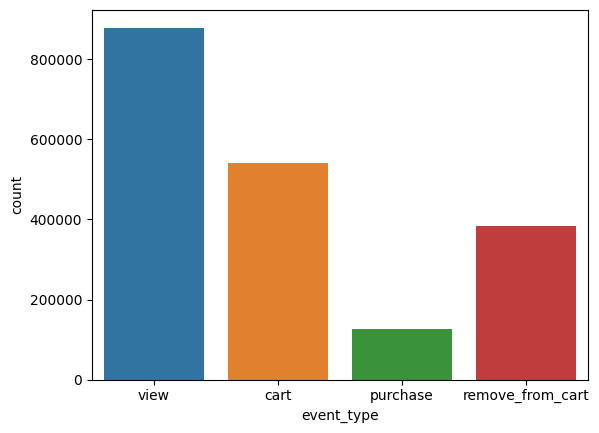

In [32]:
sns.countplot(x='event_type', data=data)

<h4>Question 6</h4>

In [128]:
session_data = data.copy()
session_data = session_data.reindex(columns=['user_session','user_id','event_time','event_type','product_id','funnel_number','index_in_funnel','duration_to_next_event'])
session_data = session_data.drop_duplicates(subset='user_session')
session_data = session_data.reset_index()
session_data.drop('index',axis=1,inplace=True)
#session_data

In [120]:
session_data['total_events'] = session_data.groupby(['user_id','user_session'])['event_time'].cumcount()+1
session_data['total_web_time'] = session_data.groupby(['user_id','user_session'])['duration_to_next_event'].cumsum()

In [132]:
session_data['list_of_viewed'] = session_data[session_data['event_type'] == 'view'].groupby(['user_id','user_session'])['product_id'].agg(list).reset_index()['product_id']

In [133]:
#session_data['event_type'].unique()

In [134]:
session_data['list_of_added_to_cart'] = session_data[session_data['event_type'] == 'cart'].groupby(['user_id','user_session'])['product_id'].agg(list).reset_index()['product_id']
session_data['list_of_purchased'] = session_data[session_data['event_type'] == 'purchase'].groupby(['user_id','user_session'])['product_id'].agg(list).reset_index()['product_id']

In [135]:
session_data = session_data.drop(columns=['event_type','product_id','duration_to_next_event','event_time'])

In [136]:
print(session_data['list_of_viewed'].isnull().sum())
print(session_data['list_of_added_to_cart'].isnull().sum())
print(session_data['list_of_purchased'].isnull().sum())

115772
859557
938006
